In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time

# Improved device setting to handle Apple Silicon MPS
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon MPS GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using NVIDIA CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

# 1. Dataset Setup - Using Food-101 dataset (101 food categories)
# Download and prepare Food-101 dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Standard size for many vision models
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
}

# Download Food-101 dataset
full_dataset = datasets.Food101(root='./data', split='train', download=True, transform=data_transforms['train'])
test_dataset = datasets.Food101(root='./data', split='test', download=True, transform=data_transforms['val'])
print(f"Food-101 dataset loaded successfully!")
print(f"Training samples: {len(full_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")

Using NVIDIA CUDA GPU
Device: cuda
Food-101 dataset loaded successfully!
Training samples: 75750
Test samples: 25250
Number of classes: 101


In [2]:
# full_dataset[0][0].shape

torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

tensor([[[0.2290]],

        [[0.2240]],

        [[0.2250]]])

Food-101 dataset loaded for visualization!


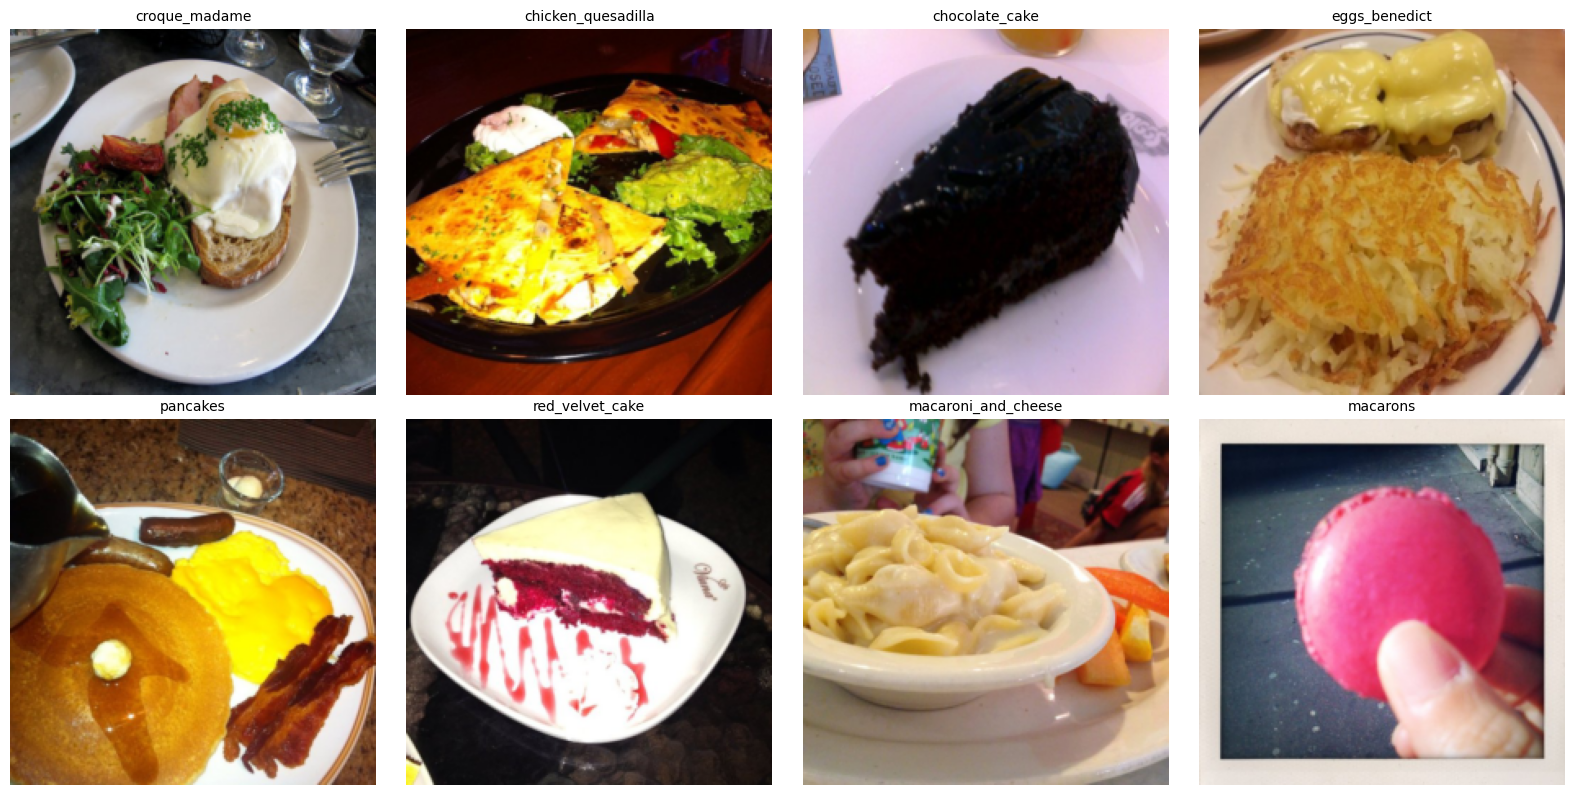

Dataset info:
- Total samples: 75750
- Number of classes: 101
- Sample classes shown: ['croque_madame', 'chicken_quesadilla', 'chocolate_cake', 'eggs_benedict', 'pancakes', 'red_velvet_cake', 'macaroni_and_cheese', 'macarons']

Food-101 Classes (first 20):
 0: apple_pie
 1: baby_back_ribs
 2: baklava
 3: beef_carpaccio
 4: beef_tartare
 5: beet_salad
 6: beignets
 7: bibimbap
 8: bread_pudding
 9: breakfast_burrito
10: bruschetta
11: caesar_salad
12: cannoli
13: caprese_salad
14: carrot_cake
15: ceviche
16: cheese_plate
17: cheesecake
18: chicken_curry
19: chicken_quesadilla
...

Image specifications:
- Shape: torch.Size([3, 224, 224])
- Data type: torch.float32
- Value range: [0.008, 1.000]
- Label type: <class 'int'>


In [3]:
# Spot check Food-101 dataset images
def spot_check_dataset(dataset, num_samples=8):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    class_names = None
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get image and label
        if hasattr(dataset, 'dataset'):  # For split datasets
            image, label = dataset.dataset[idx]
            class_names = dataset.dataset.classes
        else:
            image, label = dataset[idx]
            class_names = dataset.classes
        
        # Convert tensor to numpy for display
        if isinstance(image, torch.Tensor):
            # Denormalize if normalized
            if image.min() < 0:  # Likely normalized
                # Reverse ImageNet normalization
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                image = image * std.view(3, 1, 1) + mean.view(3, 1, 1)
                image = torch.clamp(image, 0, 1)
            
            # Convert to numpy and transpose
            image_np = image.permute(1, 2, 0).numpy()
        else:
            image_np = np.array(image)
        
        # Display image
        axes[i].imshow(image_np)
        axes[i].set_title(f'{class_names[label]}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Dataset info:")
    print(f"- Total samples: {len(dataset)}")
    print(f"- Number of classes: {len(class_names) if 'class_names' in locals() else 'Unknown'}")
    print(f"- Sample classes shown: {[class_names[dataset[idx][1]] for idx in indices] if 'class_names' in locals() else 'Unknown'}")

# Load dataset with transforms for visualization (less aggressive normalization)
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

try:
    # Load Food-101 for visualization
    viz_dataset = datasets.Food101(root='./data', split='train', download=False, transform=viz_transform)
    print("Food-101 dataset loaded for visualization!")
    spot_check_dataset(viz_dataset)
    
    # Show class distribution
    print(f"\nFood-101 Classes (first 20):")
    for i, class_name in enumerate(viz_dataset.classes[:20]):
        print(f"{i:2d}: {class_name}")
    print("...")
    
except Exception as e:
    print(f"Food-101 not available: {e}")
    print("Loading CIFAR-10 for visualization...")
    viz_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=viz_transform)
    spot_check_dataset(viz_dataset)
    
    print(f"\nCIFAR-10 Classes:")
    for i, class_name in enumerate(viz_dataset.classes):
        print(f"{i}: {class_name}")

# Check image dimensions and data types
sample_image, sample_label = viz_dataset[0]
print(f"\nImage specifications:")
print(f"- Shape: {sample_image.shape}")
print(f"- Data type: {sample_image.dtype}")
print(f"- Value range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")
print(f"- Label type: {type(sample_label)}")

In [4]:
# Split training data into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Update validation dataset transform
val_dataset.dataset.transform = data_transforms['val']

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get number of classes
num_classes = len(full_dataset.classes)

print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {num_classes}")

Train set: 60600 samples
Validation set: 15150 samples
Test set: 25250 samples
Batch size: 32
Number of classes: 101


In [5]:
# 2. Data preprocessing complete - images ready for CNN input

# 3. State-of-the-art CNN Model (ResNet-based)
class ResNetCNN(nn.Module):

    def __init__(self, num_classes):
        super(ResNetCNN, self).__init__()

        self.num_classes = num_classes

        # CNN backbone (ResNet-inspired)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        # First block
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        # Additional blocks
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Initialize model
model = ResNetCNN(num_classes=num_classes).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

# 4. Training setup with optimal hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Model created with 4785765 parameters


In [6]:
# 5. Metrics tracking with timing
class MetricsTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.train_losses = []
        self.train_accuracies = []
        self.train_precisions = []
        self.train_recalls = []

        self.val_losses = []
        self.val_accuracies = []
        self.val_precisions = []
        self.val_recalls = []

        self.batch_train_losses = []
        self.batch_val_losses = []
        
        # Timing tracking
        self.epoch_times = []
        self.train_times = []
        self.val_times = []

    def update_batch(self, loss, phase='train'):
        if phase == 'train':
            self.batch_train_losses.append(loss)
        else:
            self.batch_val_losses.append(loss)

    def calculate_metrics(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        return accuracy, precision, recall

    def update_epoch(self, loss, y_true, y_pred, phase='train'):
        accuracy, precision, recall = self.calculate_metrics(y_true, y_pred)

        if phase == 'train':
            self.train_losses.append(loss)
            self.train_accuracies.append(accuracy)
            self.train_precisions.append(precision)
            self.train_recalls.append(recall)
        else:
            self.val_losses.append(loss)
            self.val_accuracies.append(accuracy)
            self.val_precisions.append(precision)
            self.val_recalls.append(recall)
    
    def add_timing(self, epoch_time, train_time, val_time):
        self.epoch_times.append(epoch_time)
        self.train_times.append(train_time)
        self.val_times.append(val_time)

metrics_tracker = MetricsTracker()

# 6. Training function with timing
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    epoch_start_time = time.time()
    batch_times = []

    for batch_idx, (data, target) in enumerate(train_loader):
        batch_start_time = time.time()
        
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        metrics_tracker.update_batch(loss.item(), 'train')

        # Collect predictions for metrics
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        
        batch_time = time.time() - batch_start_time
        batch_times.append(batch_time)

        if batch_idx % 100 == 0:
            avg_batch_time = np.mean(batch_times[-100:])
            samples_per_sec = len(data) / avg_batch_time
            print(f'Train Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, '
                  f'Time: {batch_time:.3f}s, Speed: {samples_per_sec:.1f} samples/s')

    epoch_time = time.time() - epoch_start_time
    epoch_loss = running_loss / len(train_loader)
    metrics_tracker.update_epoch(epoch_loss, all_targets, all_preds, 'train')
    
    avg_batch_time = np.mean(batch_times)
    total_samples = len(train_loader.dataset)
    
    print(f"Training epoch completed in {epoch_time:.2f}s")
    print(f"Average batch time: {avg_batch_time:.3f}s")
    print(f"Training speed: {total_samples/epoch_time:.1f} samples/s")

    return epoch_loss, epoch_time

# 7. Validation function with timing
def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    epoch_start_time = time.time()

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            metrics_tracker.update_batch(loss.item(), 'val')

            # Collect predictions for metrics
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_time = time.time() - epoch_start_time
    epoch_loss = running_loss / len(val_loader)
    metrics_tracker.update_epoch(epoch_loss, all_targets, all_preds, 'val')
    
    total_samples = len(val_loader.dataset)
    print(f"Validation completed in {epoch_time:.2f}s")
    print(f"Validation speed: {total_samples/epoch_time:.1f} samples/s")

    return epoch_loss, epoch_time

Starting training...

Epoch 1/20
------------------------------
Train Batch 0/1894, Loss: 4.7559, Time: 0.465s, Speed: 68.7 samples/s
Train Batch 100/1894, Loss: 4.6376, Time: 0.038s, Speed: 840.2 samples/s
Train Batch 200/1894, Loss: 4.4475, Time: 0.038s, Speed: 838.8 samples/s
Train Batch 300/1894, Loss: 4.6095, Time: 0.041s, Speed: 833.1 samples/s
Train Batch 400/1894, Loss: 4.4773, Time: 0.038s, Speed: 824.4 samples/s
Train Batch 500/1894, Loss: 4.6669, Time: 0.038s, Speed: 836.7 samples/s
Train Batch 600/1894, Loss: 4.5416, Time: 0.038s, Speed: 838.4 samples/s
Train Batch 700/1894, Loss: 4.2430, Time: 0.038s, Speed: 835.3 samples/s
Train Batch 800/1894, Loss: 4.4077, Time: 0.038s, Speed: 821.1 samples/s
Train Batch 900/1894, Loss: 4.0491, Time: 0.039s, Speed: 824.0 samples/s
Train Batch 1000/1894, Loss: 4.3593, Time: 0.038s, Speed: 827.7 samples/s
Train Batch 1100/1894, Loss: 4.4355, Time: 0.039s, Speed: 825.4 samples/s
Train Batch 1200/1894, Loss: 4.1448, Time: 0.039s, Speed: 825

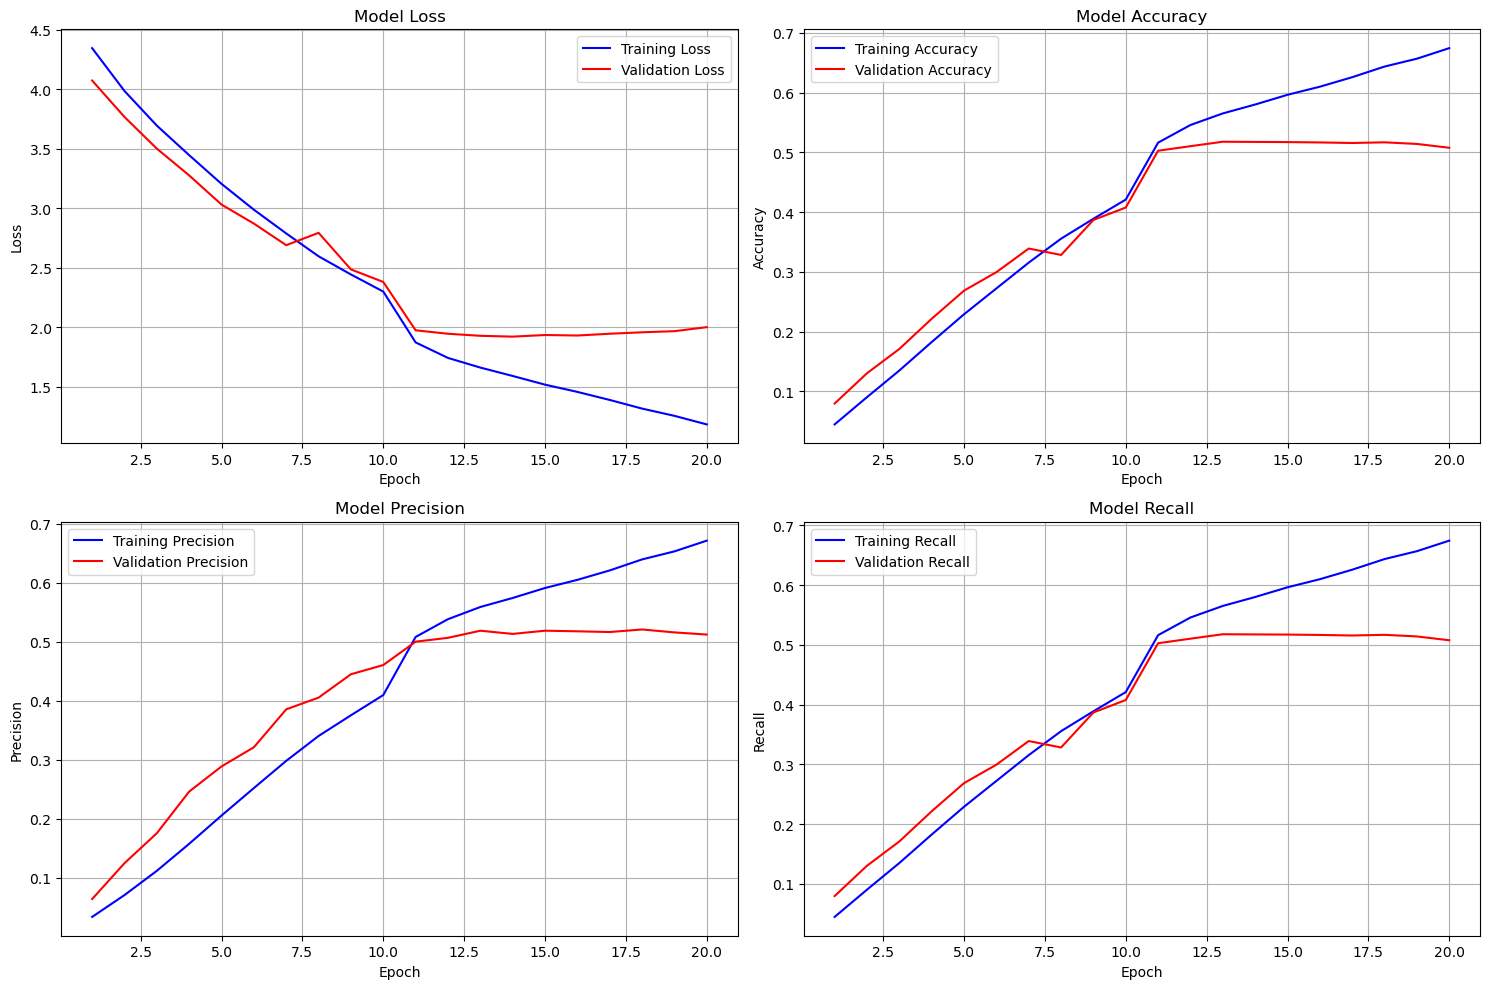

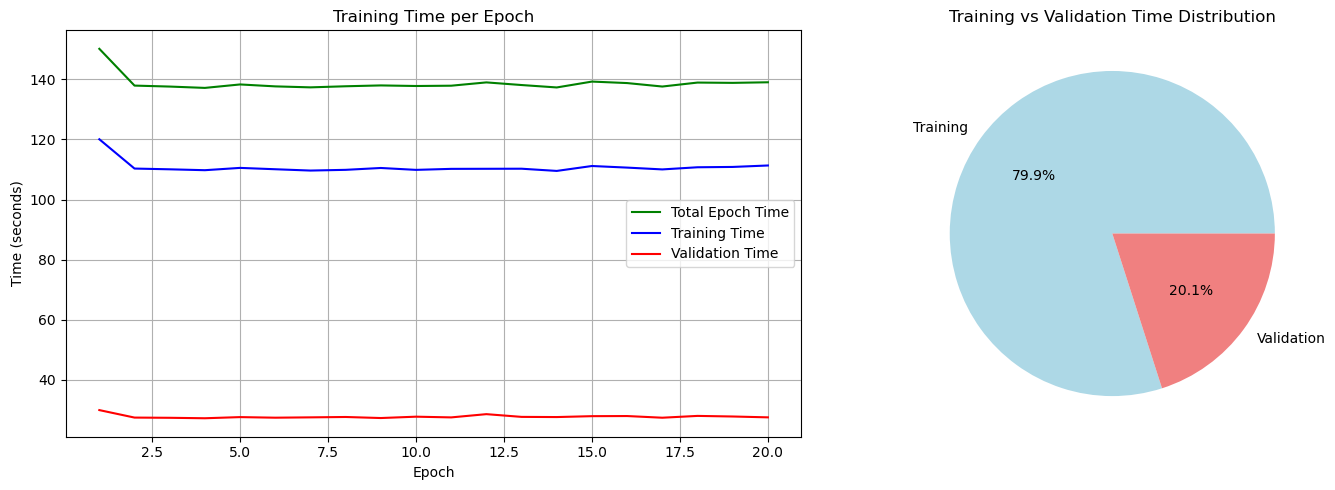


Evaluating on test set...
Validation completed in 49.86s
Validation speed: 506.4 samples/s

Final Test Results:
Test Loss: 1.6568
Test Accuracy: 0.5651
Test Precision: 0.5593
Test Recall: 0.5651
Test evaluation time: 49.95s
Test inference speed: 506.4 samples/s

🎉 Training pipeline completed successfully!
📈 Total project time: 47.11 minutes


In [7]:
# 8. Training loop with comprehensive timing
num_epochs = 20
best_val_loss = float('inf')

print("Starting training...")
print("="*50)

# Start total training timer
total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Train
    train_loss, train_time = train_epoch(model, train_loader, criterion, optimizer)

    # Validate
    val_loss, val_time = validate_epoch(model, val_loader, criterion)

    # Step scheduler
    scheduler.step()
    
    # Calculate epoch timing
    epoch_time = time.time() - epoch_start_time
    metrics_tracker.add_timing(epoch_time, train_time, val_time)

    # Print epoch results with timing
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {metrics_tracker.train_accuracies[-1]:.4f}")
    print(f"Train Precision: {metrics_tracker.train_precisions[-1]:.4f}, Train Recall: {metrics_tracker.train_recalls[-1]:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {metrics_tracker.val_accuracies[-1]:.4f}")
    print(f"Val Precision: {metrics_tracker.val_precisions[-1]:.4f}, Val Recall: {metrics_tracker.val_recalls[-1]:.4f}")
    
    # Timing summary for epoch
    print(f"Epoch timing - Total: {epoch_time:.2f}s, Train: {train_time:.2f}s, Val: {val_time:.2f}s")
    
    # Calculate and show ETA
    if epoch > 0:
        avg_epoch_time = np.mean(metrics_tracker.epoch_times)
        remaining_epochs = num_epochs - epoch - 1
        eta_seconds = avg_epoch_time * remaining_epochs
        eta_minutes = eta_seconds / 60
        print(f"ETA: {eta_minutes:.1f} minutes ({eta_seconds:.0f}s)")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved!")

# Calculate total training time
total_training_time = time.time() - total_start_time

print("\nTraining completed!")
print("="*50)

# Training time summary
print(f"\n📊 TIMING SUMMARY:")
print(f"Total training time: {total_training_time/60:.2f} minutes ({total_training_time:.1f}s)")
print(f"Average epoch time: {np.mean(metrics_tracker.epoch_times):.2f}s")
print(f"Average training time per epoch: {np.mean(metrics_tracker.train_times):.2f}s")
print(f"Average validation time per epoch: {np.mean(metrics_tracker.val_times):.2f}s")
print(f"Train/Val time ratio: {np.mean(metrics_tracker.train_times)/np.mean(metrics_tracker.val_times):.1f}:1")

# 9. Plotting results with timing
def plot_training_metrics():
    epochs = range(1, len(metrics_tracker.train_losses) + 1)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    ax1.plot(epochs, metrics_tracker.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, metrics_tracker.val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(epochs, metrics_tracker.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, metrics_tracker.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Precision
    ax3.plot(epochs, metrics_tracker.train_precisions, 'b-', label='Training Precision')
    ax3.plot(epochs, metrics_tracker.val_precisions, 'r-', label='Validation Precision')
    ax3.set_title('Model Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True)

    # Recall
    ax4.plot(epochs, metrics_tracker.train_recalls, 'b-', label='Training Recall')
    ax4.plot(epochs, metrics_tracker.val_recalls, 'r-', label='Validation Recall')
    ax4.set_title('Model Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot timing analysis
def plot_timing_analysis():
    epochs = range(1, len(metrics_tracker.epoch_times) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Epoch times
    ax1.plot(epochs, metrics_tracker.epoch_times, 'g-', label='Total Epoch Time')
    ax1.plot(epochs, metrics_tracker.train_times, 'b-', label='Training Time')
    ax1.plot(epochs, metrics_tracker.val_times, 'r-', label='Validation Time')
    ax1.set_title('Training Time per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Time (seconds)')
    ax1.legend()
    ax1.grid(True)
    
    # Time distribution pie chart
    total_train_time = sum(metrics_tracker.train_times)
    total_val_time = sum(metrics_tracker.val_times)
    ax2.pie([total_train_time, total_val_time], 
            labels=['Training', 'Validation'], 
            autopct='%1.1f%%',
            colors=['lightblue', 'lightcoral'])
    ax2.set_title('Training vs Validation Time Distribution')
    
    plt.tight_layout()
    plt.savefig('timing_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the results
plot_training_metrics()
plot_timing_analysis()

# 10. Final test evaluation with timing
print("\nEvaluating on test set...")
test_start_time = time.time()

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_time = validate_epoch(model, test_loader, criterion)

total_test_time = time.time() - test_start_time

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {metrics_tracker.val_accuracies[-1]:.4f}")
print(f"Test Precision: {metrics_tracker.val_precisions[-1]:.4f}")
print(f"Test Recall: {metrics_tracker.val_recalls[-1]:.4f}")
print(f"Test evaluation time: {total_test_time:.2f}s")
print(f"Test inference speed: {len(test_dataset)/test_time:.1f} samples/s")

print("\n🎉 Training pipeline completed successfully!")
print(f"📈 Total project time: {(time.time() - total_start_time)/60:.2f} minutes")